In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim


## File Naming Convention

Each `.pt` file should follow this format:

```
<label>_<replicate>.pt
```

**Examples:**
- `150_1.pt` → Label: 150 (undetectable), Replicate: 1
- `500_2.pt` → Label: 500 (low), Replicate: 2
- `7000_3.pt` → Label: 7000 (medium), Replicate: 3
- `20000_5.pt` → Label: 20000 (high), Replicate: 5



## Class Definitions for Semi-Quantitative approach 

Infers clinical decision-making based on viral load counts (assuming 1:1 sample prep
)
1. `undetectable` → Label values `< 200`
2. `low` → Label values `200 ≤ label ≤ 1000`
3. `medium` → Label values `1000 < label ≤ 10000`
4. `high` → Label values `> 10000`

# Dataset Folder Structure

Dataset is organized into the following structure to ensure proper training, validation, and testing:

```
Datasets/
│-- SemiQuant/
│   │-- Training/             # Training dataset (60% of total data)
│   │   ├── undetectable/      # Class 0 (e.g., files with labels < 200)
│   │   │   ├── 20_1.pt
│   │   │   ├── 40_3.pt
│   │   │   └── ...
│   │   ├── low/               # Class 1 (200 ≤ label ≤ 1000)
|   |   |   ├── 300_2.pt
│   │   │   ├── 600_4.pt
│   │   │   └── ...
│   │   ├── medium/            # Class 2 (1000 < label ≤ 10000)
│   │   │   ├── 2000_1.pt
│   │   │   ├── 7000_2.pt
│   │   │   └── ...
│   │   ├── high/              # Class 3 (label > 10000)
│   │   │   ├── 10000_2.pt
│   │   │   ├── 90000_2.pt
│   │   │   └── ...
│
│   │-- Validation/            # Validation dataset (20% of total data)
│   │   ├── undetectable/
│   │   │   ├── 20_2.pt
│   │   │   ├── 40_4.pt
│   │   │   └── ...
│   │   ├── low/
│   │   ├── medium/
│   │   ├── high/
│
│   │-- Testing/               # Testing dataset (20% of total data)
│   │   ├── undetectable/
│   │   │   ├── 30_1.pt
│   │   │   ├── 50_2.pt
│   │   │   └── ...
│   │   ├── low/
│   │   ├── medium/
│   │   ├── high/
│
│-- torch_tensors/              # Original .pt files before splitting
│   │   ├── 100_1.pt
│   │   ├── 200_3.pt
│   │   ├── 5000_2.pt
│   │   ├── 15000_4.pt
│   │   └── ...
```

## Folder Descriptions

- **`Training/`** – Used to train the model (60% of total data).
- **`Validation/`** – Used to validate the model during training (20% of total data).
- **`Testing/`** – Used to evaluate the model after training (20% of total data).
- **`torch_tensors/`** – Stores the original `.pt` files before they were split.



In [2]:
class PTDataset(Dataset):
    def __init__(self, root_dir, target_size=(500, 500), transform=None, device='cuda'):
        """
        Args:
            root_dir (str): Path to the dataset directory (e.g., Training folder).
            target_size (tuple): Desired output size (height, width).
            transform (callable, optional): Optional transformations.
            device (str): Device to perform computations ('cuda' or 'cpu').
        """
        self.root_dir = root_dir
        self.target_size = target_size
        self.transform = transform
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.classes = ['undetectable', 'low', 'medium', 'high']
        
        # Collect all file paths and labels
        self.file_list = []
        for label in self.classes:
            class_path = os.path.join(root_dir, label)
            for file in os.listdir(class_path):
                if file.endswith('.pt'):
                    self.file_list.append((os.path.join(class_path, file), self.classes.index(label)))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path, label = self.file_list[idx]

        # Load tensor from file and move to GPU
        tensor_data = torch.load(file_path, map_location=self.device)  # Shape [C, T, H, W]

        # Ensure the tensor has enough frames
        max_frames = tensor_data.shape[1]  
        selected_frame_indices = [69, 89, 109, 129, 149, 179]
        selected_frame_indices = [i for i in selected_frame_indices if i < max_frames]

        if len(selected_frame_indices) < 6:
            raise ValueError(f"Not enough frames in {file_path}, available: {max_frames}, required: 180")

        # Compute the average of the first 20 frames and select specific frames
        avg_first_20 = torch.mean(tensor_data[:, :20, :, :], dim=1, keepdim=True).to(self.device)  
        selected_frames = tensor_data[:, selected_frame_indices, :, :].to(self.device) 

        # Concatenate to form a 7-frame tensor and remove channel dim if singleton
        final_tensor = torch.cat((avg_first_20, selected_frames), dim=1)  # [C, 7, H, W]
        final_tensor = final_tensor.squeeze(0) if final_tensor.shape[0] == 1 else final_tensor.squeeze()

        # Resize tensors in a batch-wise manner instead of a loop
        resized_tensor = torch.nn.functional.interpolate(final_tensor.unsqueeze(0), size=self.target_size, mode='bilinear', align_corners=False).squeeze(0)

        # Apply transformations if provided
        if self.transform:
            resized_tensor = self.transform(resized_tensor)

        return resized_tensor.to(self.device), label

In [4]:
# Define paths data
train_dataset_path = 'H:/Datasets/int_split/Training/'
val_dataset_path = 'H:/Datasets/int_split/Validation/'
test_dataset_path = 'H:/Datasets/int_split/Testing/'

# Load datasets
train_dataset = PTDataset(root_dir=train_dataset_path, target_size=(500, 500))
val_dataset = PTDataset(root_dir=val_dataset_path, target_size=(500, 500))
test_dataset = PTDataset(root_dir=test_dataset_path, target_size=(500, 500))

#DataLoaders

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

use_pin_memory = True if device.type == 'cuda' else False

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

for batch in train_loader:
    inputs, labels = batch
    print(f"Batch input shape: {inputs.shape}")  # Expected [batch_size, 7, 224, 224]
    print(f"Batch labels: {labels}")
    break


C:\Users\Colem\AppData\Local\Temp\ipykernel_7196\1946887731.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_data = torch.load(file_path, map_location=self.device

Batch input shape: torch.Size([32, 7, 500, 500])
Batch labels: tensor([0, 3, 3, 3, 0, 3, 3, 3, 3, 0, 0, 3, 2, 3, 2, 3, 1, 0, 3, 3, 3, 1, 2, 3,
        2, 2, 3, 0, 3, 0, 1, 2])


In [6]:
def estimate_dataset_size(dataset):
    # Get one sample to compute size
    sample, _ = dataset[0]
    
    # Calculate memory size of the sample
    sample_size_bytes = sample.element_size() * sample.numel()

    # Estimate total dataset size
    num_samples = len(dataset)
    total_size_bytes = sample_size_bytes * num_samples

    # Convert to GB
    total_size_gb = total_size_bytes / (1024 ** 3)
    
    return total_size_gb


# Load dataset and calculate size
size_gb = estimate_dataset_size(train_dataset)+estimate_dataset_size(test_dataset)+estimate_dataset_size(val_dataset)
print(f"Estimated dataset size: {size_gb:.2f} GB")


C:\Users\Colem\AppData\Local\Temp\ipykernel_8124\1946887731.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_data = torch.load(file_path, map_location=self.device

Estimated dataset size: 1.54 GB


C:\Users\Colem\AppData\Local\Temp\ipykernel_8124\1946887731.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_data = torch.load(file_path, map_location=self.device

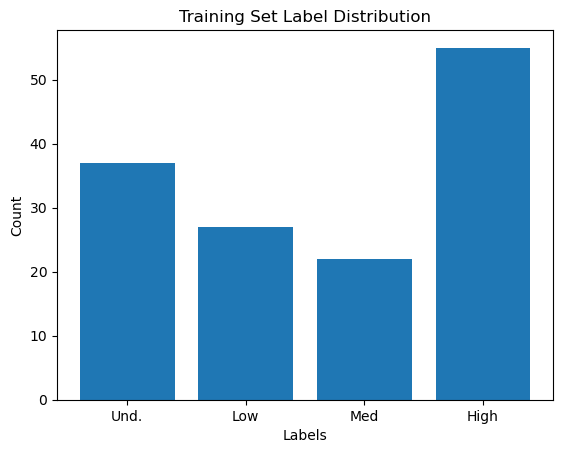

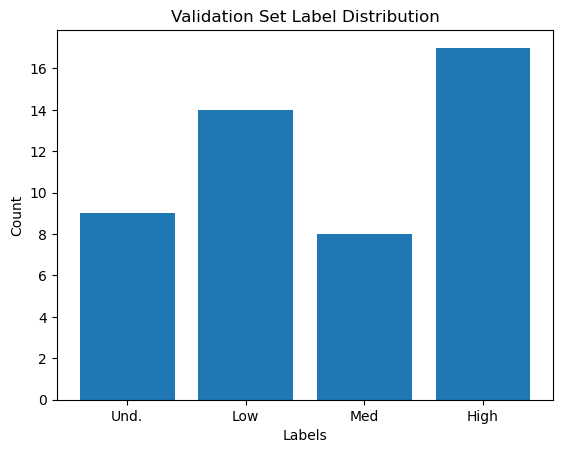

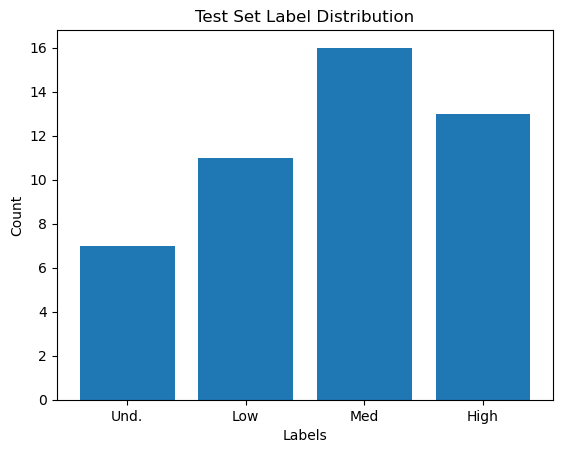

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

def get_label_distribution(dataset):
    labels = [label for _, label in dataset]  # Assuming (data, label) format
    label_counts = Counter(labels)
    return label_counts

label_mapping = {0: "Und.", 1: "Low", 2: "Med", 3: "High"}

train_label_counts = get_label_distribution(train_dataset)
val_label_counts = get_label_distribution(val_dataset)
test_label_counts = get_label_distribution(test_dataset)

def plot_label_distribution(label_counts, title):
    labels, counts = zip(*sorted(label_counts.items()))  
    custom_labels = [label_mapping[label] for label in labels] 
    
    plt.bar(custom_labels, counts)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

# Plot distributions
plot_label_distribution(train_label_counts, "Training Set Label Distribution")
plot_label_distribution(val_label_counts, "Validation Set Label Distribution")
plot_label_distribution(test_label_counts, "Test Set Label Distribution")


In [5]:
def get_resnet_model(num_classes=4, input_channels=7):
    model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
    model.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# Check for CUDA availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_resnet_model(num_classes=4, input_channels=7).to(device)
criterion = nn.BCEWithLogitsLoss()  # Use Binary Cross Entropy Loss for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Mixed precision training setup
scaler = torch.cuda.amp.GradScaler()

def one_hot_encode(labels, num_classes):
    return F.one_hot(torch.tensor(labels, dtype=torch.int64), num_classes=num_classes).float()

def train_model(model, train_loader, val_loader, criterion, optimizer, num_classes=4, num_epochs=10, training_history=None, val_history=None):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # One-hot encode labels
            labels_one_hot = one_hot_encode(labels, num_classes).to(device)

            optimizer.zero_grad()

            # Use mixed precision for faster training
            with torch.cuda.amp.autocast():
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels_one_hot)  # Compute loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

            # Convert sigmoid outputs to probabilities
            predicted = torch.sigmoid(outputs)
            predicted_classes = predicted.argmax(dim=1)

            correct += (predicted_classes == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        if training_history is not None:
            training_history.append(epoch_loss)

        val_loss, val_acc = evaluate_model(model, val_loader, criterion, num_classes)
        if val_history is not None:
            val_history.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    print("Training complete.")

def evaluate_model(model, loader, criterion, num_classes=4):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            labels_one_hot = one_hot_encode(labels, num_classes).to(device)

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels_one_hot)

            running_loss += loss.item()
            predicted_classes = torch.sigmoid(outputs).argmax(dim=1)

            correct += (predicted_classes == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\Colem/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100.0%
C:\Users\Colem\AppData\Local\Temp\ipykernel_7196\3435578905.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [6]:
model = model.to(device)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

C:\Users\Colem\AppData\Local\Temp\ipykernel_7196\1946887731.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_data = torch.load(file_path, map_location=self.device

Test Loss: 9.1165, Test Accuracy: 34.69%
Epoch 1/10, Loss: 0.4561, Accuracy: 60.28%, Val Loss: 9.1165, Val Accuracy: 34.69%
Test Loss: 9.1165, Test Accuracy: 34.69%
Epoch 2/10, Loss: 10.5706, Accuracy: 39.01%, Val Loss: 9.1165, Val Accuracy: 34.69%
Test Loss: 0.5834, Test Accuracy: 36.73%
Epoch 3/10, Loss: 10.1305, Accuracy: 39.01%, Val Loss: 0.5834, Val Accuracy: 36.73%
Test Loss: 0.6723, Test Accuracy: 16.33%
Epoch 4/10, Loss: 0.6867, Accuracy: 39.01%, Val Loss: 0.6723, Val Accuracy: 16.33%
Test Loss: 13.5379, Test Accuracy: 38.78%
Epoch 5/10, Loss: 4.4993, Accuracy: 44.68%, Val Loss: 13.5379, Val Accuracy: 38.78%
Test Loss: 0.6361, Test Accuracy: 24.49%
Epoch 6/10, Loss: 4.7527, Accuracy: 34.75%, Val Loss: 0.6361, Val Accuracy: 24.49%
Test Loss: 0.5541, Test Accuracy: 34.69%
Epoch 7/10, Loss: 0.6705, Accuracy: 34.04%, Val Loss: 0.5541, Val Accuracy: 34.69%
Test Loss: 0.6465, Test Accuracy: 16.33%
Epoch 8/10, Loss: 0.5914, Accuracy: 39.01%, Val Loss: 0.6465, Val Accuracy: 16.33%
Test

In [7]:
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

torch.save(model.state_dict(), 'resnet_model.pth')
print("Model saved as resnet_model.pth")

model.load_state_dict(torch.load('resnet_model.pth'))
model.eval()
print("Model loaded for inference.")

C:\Users\Colem\AppData\Local\Temp\ipykernel_7196\1946887731.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_data = torch.load(file_path, map_location=self.device

Test Loss: 0.4970, Test Accuracy: 28.26%
Final Test Loss: 0.4970, Test Accuracy: 28.26%
Model saved as resnet_model.pth
Model loaded for inference.


C:\Users\Colem\AppData\Local\Temp\ipykernel_7196\2137013694.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet_model.pth'))


C:\Users\Colem\AppData\Local\Temp\ipykernel_7196\1946887731.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_data = torch.load(file_path, map_location=self.device

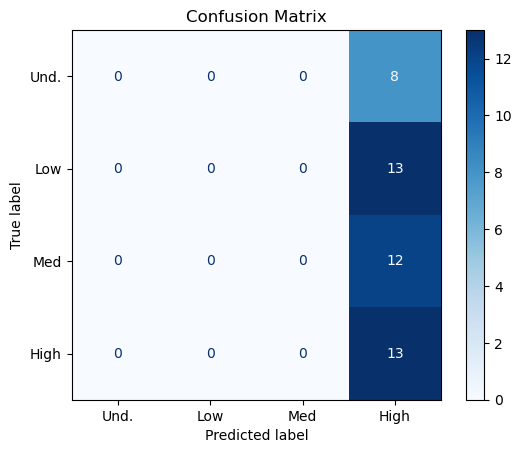

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure the model is in evaluation mode
model.eval()

# Move model to appropriate device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Collect all true labels and predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:  
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy()) 
        all_labels.extend(labels.cpu().numpy())  

conf_matrix = confusion_matrix(all_labels, all_preds)

class_names = ['Und.', 'Low', 'Med', 'High']  


disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


C:\Users\Colem\AppData\Local\Temp\ipykernel_7196\1946887731.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_data = torch.load(file_path, map_location=self.device

0


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

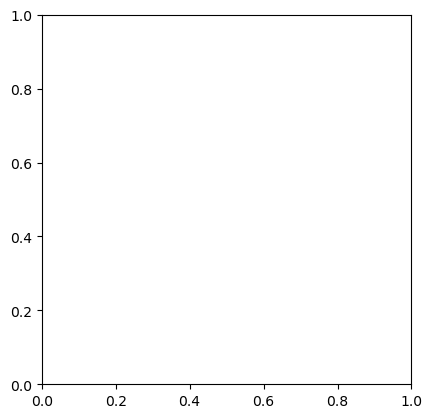

In [10]:
print(train_dataset[7][1])
plt.imshow(train_dataset[7][0][-1,:,:])